In [1]:
from pandas import read_csv
from datetime import datetime

root_dir = "/Users/trevorwiebe/Ktor/radar_backend/radar_data/"

# load data
def parse(x):
 return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv(root_dir + 'data/test_pollution_data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv(root_dir + 'data/pollution.csv')

/var/folders/rh/twp4jxnj0mb4z9rpv0nbw8nw0000gn/T/ipykernel_14105/168074959.py:9: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dataset = read_csv(root_dir + 'data/test_pollution_data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
/var/folders/rh/twp4jxnj0mb4z9rpv0nbw8nw0000gn/T/ipykernel_14105/168074959.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = read_csv(root_dir + 'data/test_pollution_data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
/var/folders/rh/twp4jxnj0mb4z9rpv0nbw8nw0000gn/T/ipykernel_14105/168074959.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assign

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


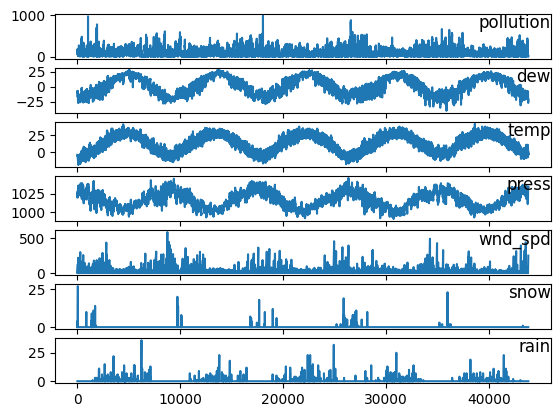

In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv(root_dir + 'data/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
dataset

In [3]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv(root_dir + 'data/pollution.csv', header=0, index_col=0)
values = dataset.values
print("Starting values")
print(values[:1])
print()

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
print("Wind direction encoded")
print(values[:1])
print()

# ensure all data is float
values = values.astype('float32')
print("Float 32")
print(values[:1])
print()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print("Min-Max scalar")
print(scaled[:1])
print()

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
print("Series to supervised")
print(reframed[:1])
print()

# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print("Remove columns we dont want to predict")
print(reframed[:1])
print()

Starting values
[[129.0 -16 -4.0 1020.0 'SE' 1.79 0 0]]

Wind direction encoded
[[129.0 -16 -4.0 1020.0 2 1.79 0 0]]

Float 32
[[ 129.    -16.     -4.   1020.      2.      1.79    0.      0.  ]]

Min-Max scalar
[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]]

Series to supervised
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   

   var7(t-1)  var8(t-1)  var1(t)  var2(t)  var3(t)  var4(t)  var5(t)  var6(t)  \
1        0.0        0.0    148.0    -15.0     -4.0   1020.0      2.0     2.68   

   var7(t)  var8(t)  
1      0.0      0.0  

Remove columns we dont want to predict
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  



In [45]:
# split into train and test sets
values = reframed.values
# print(values[:1])
# print()
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(train.shape)
print()
print(train[:1])
print()
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape)
print()
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape)

(8760, 9)

[[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.         0.14889336]]

(8760, 8)

(8760, 8)

(8760, 1, 8)
